<a href="https://colab.research.google.com/github/kayteeflick/nma_cn_flow_state/blob/phase_spike_coherence/phase_relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow State Template Analysis File

General functions to use in all notebooks. Make a copy of this to start a new type of analysis.




## Imports

In [89]:
#title 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.cm as cm

## Data Retrieval - spikes

In [90]:
#title Data retrieval - spikes
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [91]:
alldat[11]['mouse_name']

'Lederberg'

In [92]:
alldat[11]['date_exp']

'2017-12-05'

## Data retrieval - LFP

In [93]:
 
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Functions

In [94]:
# commmon functions

def select_brois(data, brois, data_type, selection=True):
  '''
  Args:
    data: a numpy array of the Steinmetz 2019 data
    brois: a list of brain regions of interest
    data_type: "LFP" or "spikes"
    selection: if True|, filters for sessions that contain all brois. If False, filters
        for sessions that contain any of the brois
  Returns:
    an embedded 1-d numpy array, with length = number of filtered session
  '''
  selected_data = np.array([])

  if data_type == "LFP":
    brain_area = "brain_area_lfp"
  elif data_type == "spikes":
    brain_area = "brain_area"

  if selection == True:
    for i in range(len(data)):
      if all(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))
  else:
    for i in range(len(data)):
      if any(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))

  return selected_data

def sel_neurons():
  print('todo')
  return

def spks_to_rate(spks):
  print('todo')
  return

def butter_bandpass_backend(lowcut, highcut, fs, order=6):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter_good_func(data, lowcut, highcut, fs, order=6):
  b, a = butter_bandpass_backend(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, data)
  return y 

def get_behavioral_idx(alldat,recording_session):
  temp_dat = alldat[recording_session]
  response = temp_dat['response'] # right - nogo - left (-1, 0, 1)
  vis_right = temp_dat['contrast_right'] # 0 - low - high
  vis_left = temp_dat['contrast_left'] # 0 - low - high
  gocue_idx = temp_dat['gocue']
  rt_idx = temp_dat['reaction_time']
  return response, vis_right, vis_left, gocue_idx, rt_idx


## Testing Filter Function

In [95]:
# brain regions of interest
# brois = ["ACA", "CA1", "DG", "MRN", "PL","VISp", "ZI"]
brois = ["CA1","SUB"]

#filtered_spikes = select_brois(alldat, brois, "spikes")
#print(len(filtered_spikes))

filtered_lfp = select_brois(dat_LFP, brois, "LFP")
print(len(filtered_lfp))

8


##Testing Bandpass Function 

In [130]:
dat['lfp'].shape

(12, 340, 250)

In [137]:
data_ref = np.dstack((dat['lfp'][:,:,::-1],dat['lfp'], dat['lfp'][:,:,::-1]))

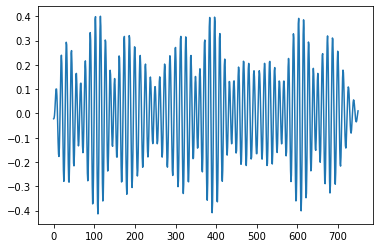

In [138]:
#pulling LFP Data of mouse 11 
dat = dat_LFP[11]
# Sample rate and desired cutoff frequencies (in Hz).
fs = 100.0
lowcut = 7.0
highcut = 9.0
filt_data = butter_bandpass_filter_good_func(data_ref, lowcut, highcut, fs,order=5)
#plotting 
test = np.mean(filt_data,axis=0)
plt.plot(np.mean(test,axis=0))

In [139]:
import scipy.signal as ss

In [140]:
hilb_data = ss.hilbert(filt_data)

In [142]:
hilb_data = hilb_data[:,:,250:500]

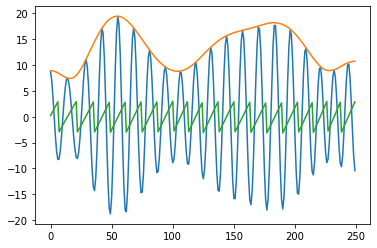

In [144]:
plt.plot(filt_data[0,0,250:500])
plt.plot(np.abs(hilb_data[0,0]))
plt.plot(np.angle(hilb_data[0,0]))

In [145]:
sess = 11
np.array(dat_LFP[sess]['brain_area_lfp'])

array(['DG', 'LGd', 'SUB', 'VISp', 'ACA', 'MOs', 'PL', 'CA1', 'DG', 'LH',
       'MD', 'VISam'], dtype='<U5')

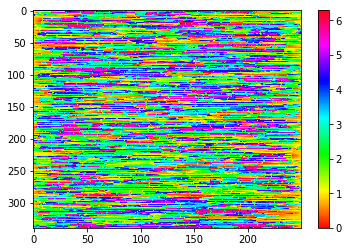

In [146]:
brain_areas = ['CA1', 'SUB']
sess = 11

ind = [i for i in range(len(dat_LFP[sess]['brain_area_lfp'])) if dat_LFP[sess]['brain_area_lfp'][i] in brain_areas]

plt.imshow(((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi), aspect='auto', cmap='hsv', vmin=0, vmax=2*np.pi)
plt.colorbar()

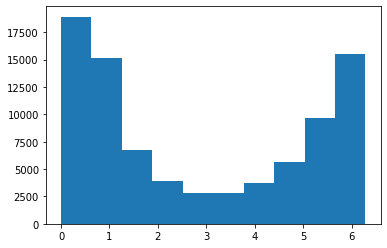

In [147]:
_ = plt.hist(((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi).reshape((-1)))

In [148]:
hilb_data.shape

(12, 340, 250)

In [149]:
all_hists = []
for i in range(hilb_data.shape[2]):
  temp, phase_lims = np.histogram((np.angle(hilb_data[ind[0],:,i]) - np.angle(hilb_data[ind[1],:,i]) + 2*np.pi) % 2*np.pi, range=(0,2*np.pi), bins=20)
  all_hists.append(temp)
all_hists = np.array(all_hists)
all_hists.shape

(250, 20)

In [150]:
phase_bins = (phase_lims[1:] + phase_lims[:-1]) / 2
phase_bins.shape

(20,)

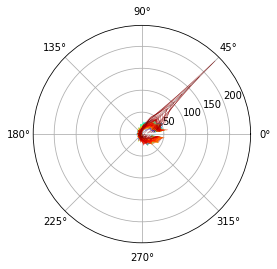

In [151]:
c = np.arange(all_hists.shape[0])
c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
for i in range(all_hists.shape[0])[30:]:
  plt.polar(phase_bins, all_hists[i], color=c[i], linewidth=0.3)

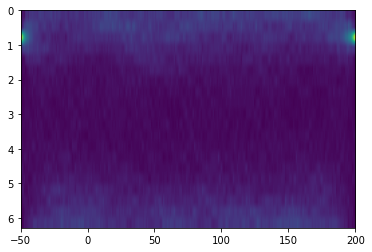

In [152]:
plt.imshow(all_hists.T, aspect='auto', extent=[-50,200,2*np.pi, 0])

In [153]:
def plot_colourline(x,y,c):
    c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    for i in np.arange(len(x)-1):
        plt.polar([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

In [154]:
hilb_data.shape

(12, 340, 250)

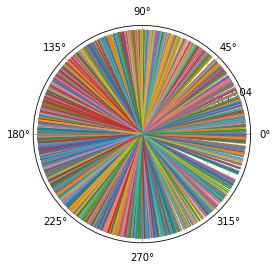

In [155]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = np.arange(hilb_data.shape[2])
c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))

phase = ((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi) - np.pi
amp = np.abs(np.exp(1j * ((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi) - np.pi))
for i in range(phase.shape[1])[0:10]:
  for j in range(phase.shape[0]):
    ax.plot([phase[j,i], phase[j,i]], [0,amp[j,i]])

In [156]:
mean_amp = (1. / hilb_data.shape[1]) * np.sum(np.exp(1j * ((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi) - np.pi), axis=0)
mean_phase = np.mean(((np.angle(hilb_data[ind[0]]) - np.angle(hilb_data[ind[1]]) + 2*np.pi) % 2*np.pi) - np.pi, axis=0)

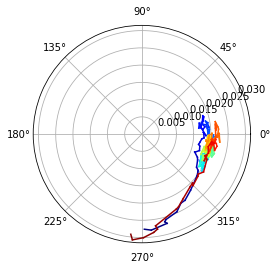

In [157]:
plot_colourline(mean_phase, np.abs(mean_amp), np.arange(len(mean_phase)))

## Phase Spike Coherence

In [128]:
#alldat[sess]['brain_area']

In [158]:
#Requires getting hilb_data from above
sess = 11
hilb_lfp = hilb_data[np.array(dat_LFP[sess]['brain_area_lfp'])=='CA1'][0]#[:,25:]
idx = alldat[sess]['brain_area']=='CA1'
spikes = alldat[sess]['spks'][idx]#[:,25:]

In [159]:
phase_all = np.angle(hilb_lfp) + np.pi
phase_all.shape

(340, 250)

In [160]:
num_bins=40

bin_counts = np.empty((len(spikes), num_bins), dtype=int)
phase_bins = np.linspace(0,2*np.pi,num_bins+1)
for i in range(len(phase_bins)-1):
  idx = np.logical_and(phase_all>phase_bins[i], phase_all<phase_bins[i+1])
  counts = np.sum(spikes[:,idx], axis=1)
  bin_counts[:,i] = counts
bin_counts = bin_counts / np.sum(bin_counts, axis=1)[:,None]

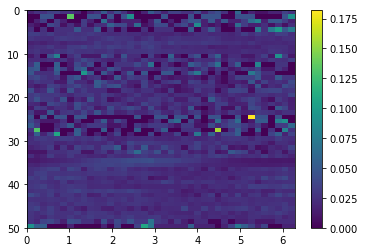

In [161]:
plt.imshow(bin_counts, aspect='auto', extent=[0, 2*np.pi, len(spikes), 0])
plt.colorbar()

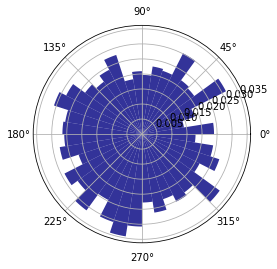

In [162]:
bottom = 0
max_height = 1

theta = (phase_bins[1:] + phase_bins[:-1]) / 2
radii = bin_counts[33]
N = len(theta)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

In [ ]:
hilb_data[np.array(dat_LFP[sess]['brain_area_lfp'])=='CA1'][0].shape

In [ ]:
plt.plot(hilb_data[np.array(dat_LFP[sess]['brain_area_lfp'])=='CA1'][0][0])
plt.scatter(np.argwhere(np.logical_and(phase_all[0]>(np.pi/2-0.3), phase_all[0]<(np.pi/2+0.3)))[:,0],\
         phase_all[0][np.logical_and(phase_all[0]>(np.pi/2-0.3), phase_all[0]<(np.pi/2+0.3))])